# Dogs vs Cat Redux

In this tutorial, you will learn how generate and submit predictions to a Kaggle competiton

[Dogs vs. Cats Redux: Kernels Edition](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition)
    
    

To start you will need to download and unzip the competition data from Kaggle and ensure your directory structure looks like this
```
utils/
    vgg16.py
    utils.py
lesson1/
    redux.ipynb
    data/
        redux/
            train/
                cat.437.jpg
                dog.9924.jpg
                cat.1029.jpg
                dog.4374.jpg
            test/
                231.jpg
                325.jpg
                1235.jpg
                9923.jpg
```

You can download the data files from the competition page [here](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data) or you can download them from the command line using the [Kaggle CLI](https://github.com/floydwch/kaggle-cli).

You should launch your notebook inside the lesson1 directory
```
cd lesson1
jupyter notebook
```

In [1]:
#Verify we are in the lesson1 directory
%pwd

'C:\\pythonProject\\courses\\deeplearning1\\nbs'

In [2]:
#Create references to important directories we will use over and over
import os, sys
current_dir = os.getcwd()
LESSON_HOME_DIR = current_dir
DATA_HOME_DIR = current_dir+'\\data\\redux'

In [3]:
#Allow relative imports to directories above lesson1/
sys.path.insert(1, os.path.join(sys.path[0], '..'))

#import modules
from imp import reload 
import utils;
#reload(utils)
#from vgg16 import Vgg16

#Instantiate plotting tool
#In Jupyter notebooks, you will need to run this command before doing any plotting
%matplotlib inline

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
# 自己定义一个Vgg16的类，封装起来。

import os, json
from glob import glob
import numpy as np
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential
from keras.layers import Input,Dense,Activation,ZeroPadding2D,Dropout,Conv2D,MaxPool2D,Flatten,Lambda,BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing import image

# In case we are going to use the TensorFlow backend we need to explicitly set the Theano image ordering
from keras import backend as K
K.set_image_dim_ordering('th')



vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((3,1,1))
def vgg_preprocess(x):
    """
        Subtracts the mean RGB value, and transposes RGB to BGR.
        The mean RGB was computed on the image set used to train the VGG model.

        Args: 
            x: Image array (height x width x channels)
        Returns:
            Image array (height x width x transposed_channels)
    """
    x = x - vgg_mean
    return x[:, ::-1] # reverse axis rgb->bgr


class Vgg16():
    
    """
    Vgg 16模型实现
    """
    
    def __init__(self):
        self.FILES_PATH = 'http://files.fast.ai/models/'
        self.create()
        self.get_classes()
       
        
    def get_classes(self):
        """
        下载Imagenet的图片分类，存在缓冲中目录为.keras
        """
        # 暂时使用fast.ai的目录
        fname='imagenet_class_index.json'

        fpath = get_file(fname,self.FILES_PATH+fname,cache_dir='models')
        with open(fpath) as f:
            class_dict = json.load(f)
        self.classes = [class_dict[str(i)][1] for i in range(len(class_dict))]
        
    def predict(self,imgs,detail=False):
        """
            Predict the labels of a set of images using the VGG16 model.

            Args:
                imgs (ndarray)    : An array of N images (size: N x width x height x channels).
                details : ??
            
            Returns:
                preds (np.array) : Highest confidence value of the predictions for each image.
                idxs (np.ndarray): Class index of the predictions with the max confidence.
                classes (list)   : Class labels of the predictions with the max confidence.
        """
        
        all_preds = self.model.predict(imgs)
        print(all_preds)
        idxs = np.argmax(all_preds,axis=1)
        preds = [all_preds[i,idxs[i]] for i in range(len(idxs))]
        classes = [self.classes[idx] for idx in idxs]
        return np.array(preds),idxs,classes
    
    def ConvBlock(self,n_layers,n_filters):
        """
            Adds a specified number of ZeroPadding and Covolution layers
            to the model, and a MaxPooling layer at the very end.

            Args:
                layers (int):   The number of zero padded convolution layers
                                to be added to the model.
                filters (int):  The number of convolution filters to be 
                                created for each layer.
        """
        model = self.model
        for layer in range(n_layers):
                model.add(ZeroPadding2D(padding=(1,1)))
                model.add(Conv2D(filters=n_filters,kernel_size=(3,3),strides=(1,1),activation='relu'))
        model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
        
        
        
    def FcBlock(self):
        """
            Adds a fully connected layer of 4096 neurons to the model with a
            Dropout of 0.5

            Args:   None
            Returns:   None
        """
        model = self.model
        model.add(Dense(4096,activation='relu')) # FC1
        model.add(Dropout(rate=0.5))
        
    def create(self):
        """
            Creates the VGG16 network achitecture and loads the pretrained weights.

            Args:   None
            Returns:   None
        """
        model = self.model = Sequential()
        #  顺序 (Sequential) 模型写法第一add 必须加input_shape
        model.add(Lambda(vgg_preprocess, input_shape=(3,224,224), output_shape=(3,224,224)))

        self.ConvBlock(2,64) # 最开始的2层用64个3x3的过滤器，然后pool
        self.ConvBlock(2,128)
        self.ConvBlock(3,256)
        self.ConvBlock(3,512)
        self.ConvBlock(3,512)

        model.add(Flatten()) # 拉平，展开
        self.FcBlock()
        self.FcBlock()
        model.add(Dense(1000,activation='softmax')) # 1000个分类
        
        # 读取预训练好的模型权重
        fpath = get_file('vgg16.h5', self.FILES_PATH+'vgg16.h5', cache_subdir='models') # 读取训练好的权重
        
        model.load_weights(fpath)
        
            
    def get_batches(self,path,gen = image.ImageDataGenerator(),class_mode='categorical',batch_size=4,shuffle=True):
        """
            Takes the path to a directory, and generates batches of augmented/normalized data. Yields batches indefinitely, in an infinite loop.

            See Keras documentation: https://keras.io/preprocessing/image/
        """
        return gen.flow_from_directory(path,target_size=(224,224),
                                   class_mode=class_mode,batch_size=batch_size,shuffle=shuffle)
    
            
    def ft(self,n_neurons):
        """
            冻结vgg16出去最后一层softmax 1000的全连接层，改为 传递进去的神经元个数
            Replace the last layer of the model with a Dense (fully connected) layer of num neurons.
            Will also lock the weights of all layers except the new layer so that we only learn
            weights for the last layer in subsequent training.

            Args:
                num (int) : Number of neurons in the Dense layer
            Returns:
                None
        """
        model = self.model
        model.pop()
        for layer in model.layers:
            layer.trainable = False # 这些层不训练
        model.add(Dense(n_neurons,activation='softmax'))
        self.compile()
        
        
    
    def finetune(self,batches):
        """
            # 微调模型,更新self.classes 不同的数据需要变动这里。
            Modifies the original VGG16 network architecture and updates self.classes for new training data.
            
            Args:
                batches : A keras.preprocessing.image.ImageDataGenerator object.
                          See definition for get_batches().
        """
        self.ft(batches.num_classes) # 获得数据的类别个数
        classes = list(iter(batches.class_indices)) # get a list of all the class labels
        
        # batches.class_indices is a dict with the class name as key and an index as value
        # eg. {'cats': 0, 'dogs': 1}

        # sort the class labels by index according to batches.class_indices and update model.classes
        for c in batches.class_indices:
            classes[batches.class_indices[c]] = c
        self.classes = classes
        
            
    def compile(self,lr=0.01):
        """
            用于配置训练模型。
            Configures the model for training.
            See Keras documentation: https://keras.io/models/model/
        """
        self.model.compile(optimizer=Adam(lr=lr),loss='categorical_crossentropy',metrics=['accuracy'])
        
        
        
    def fit_data(self,X,y,val,val_lables,batch_size=64,n_epochs=3):
        """
            # 训练模型
            See Keras documentation: https://keras.io/models/model/
        """
        self.model.fit(X,y,validation_data=(val,val_labels),epochs=n_epochs,batch_size=batch_size)
    
    
    def fit(self,batches,val_batches,n_epochs=3):
        """
            使用 Python 生成器逐批生成的数据，按批次训练模型。
            Fits the model on data yielded batch-by-batch by a Python generator.
            See Keras documentation: https://keras.io/models/model/
        """
        self.model.fit_generator(batches,validation_data=val_batches,epochs=n_epochs,verbose=1)
        
        
    def test(self,path,batch_size=8):
        """
            测试
            Predicts the classes using the trained model on data yielded batch-by-batch.

            Args:
                path (string):  Path to the target directory. It should contain one subdirectory 
                                per class.
                batch_size (int): The number of images to be considered in each batch.
            
            Returns:
                test_batches, numpy array(s) of predictions for the test_batches.
    
        """
        test_batches = self.get_batches(path,shuffle=False,batch_size=batch_size,class_mode=None)
        return test_batches,self.model.predict_generator(test_batches)

## 计划
1. Create Validation and Sample sets
2. Rearrange image files into their respective directories 
3. Finetune and Train model
4. Generate predictions
5. Validate predictions
6. Submit predictions to Kaggle

## 建立验证集和样本

In [ ]:
DATA_HOME_DIR

In [ ]:
#Create directories 如果是linux系统
%mkdir DATA_HOME_DIR
%cd $DATA_HOME_DIR
%mkdir valid
%mkdir results
%mkdir sample/train
%mkdir sample/test
%mkdir sample/valid
%mkdir sample/results
%mkdir test/unknown

In [ ]:
#Create directories 如果是Windows10 系统
%mkdir $DATA_HOME_DIR
%cd $DATA_HOME_DIR
%mkdir valid
%mkdir results
%mkdir sample\\train
%mkdir sample\\test
%mkdir sample\\valid
%mkdir sample\\results
%mkdir test\\unknown

In [ ]:
DATA_HOME_DIR

In [ ]:
%cd $DATA_HOME_DIR\train

In [ ]:
# linux系统
# %cd $DATA_HOME_DIR/train 

In [ ]:
from glob import glob
import numpy as np

In [ ]:
g = glob('*.jpg',recursive=True)
#print(g)
shuf = np.random.permutation(g)
for i in range(2000): 
    os.rename(shuf[i], DATA_HOME_DIR+'\\valid\\' + shuf[i])

In [ ]:
from shutil import copyfile

In [ ]:
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(200): 
    copyfile(shuf[i], DATA_HOME_DIR+'\\sample\\train\\' + shuf[i])

In [ ]:
%cd $DATA_HOME_DIR\valid

In [ ]:
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(50): 
    copyfile(shuf[i], DATA_HOME_DIR+'\\sample\\valid\\' + shuf[i])

## 重新组织图片到相应文件夹

In [ ]:
%cd $DATA_HOME_DIR\sample\train
%mkdir cats
%mkdir dogs
%dir
%move cat.*.jpg cats
%move dog.*.jpg dogs

In [ ]:
#Divide cat/dog images into separate directories

%cd $DATA_HOME_DIR\sample\train
%mkdir cats
%mkdir dogs
# %move cat.*.jpg cats
# %move dog.*.jpg dogs

%cd $DATA_HOME_DIR\sample\valid
%mkdir cats
%mkdir dogs
# %move cat.*.jpg cats/
# %move dog.*.jpg dogs/

%cd $DATA_HOME_DIR\valid
%mkdir cats
%mkdir dogs
# %move cat.*.jpg cats/
# %move dog.*.jpg dogs/

%cd $DATA_HOME_DIR\train
%mkdir cats
%mkdir dogs
# %move cat.*.jpg cats/
# %move dog.*.jpg dogs/

In [ ]:
# Create single 'unknown' class for test set
%cd $DATA_HOME_DIR\test
%move *.jpg unknown\

## 微调模型&训练

In [ ]:
DATA_HOME_DIR

In [5]:
%cd $DATA_HOME_DIR

#Set path to sample/ path if desired
path = DATA_HOME_DIR + '\\' #'/sample/'
test_path = DATA_HOME_DIR + '\\test\\' #We use all the test data
results_path=DATA_HOME_DIR + '\\results\\'
train_path=path + '\\train\\'
valid_path=path + '\\valid\\'

C:\pythonProject\courses\deeplearning1\nbs\data\redux


In [6]:
#import Vgg16 helper class
vgg = Vgg16()

In [7]:
#Set constants. You can experiment with no_of_epochs to improve the model
batch_size=16
no_of_epochs=3

In [8]:
#Finetune the model
batches = vgg.get_batches(train_path, batch_size=batch_size)
val_batches = vgg.get_batches(valid_path, batch_size=batch_size)
vgg.finetune(batches)

#Not sure if we set this for all fits
vgg.model.optimizer.lr = 0.01

Found 21759 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [9]:
#Notice we are passing in the validation dataset to the fit() method
#For each epoch we test our model against the validation set
latest_weights_filename = None
for epoch in range(no_of_epochs):
    print("Running epoch: %d" % epoch)
    vgg.fit(batches, val_batches, n_epochs=1) # 按批次训练模型
    latest_weights_filename = 'ft%d.h5' % epoch
    vgg.model.save_weights(results_path+latest_weights_filename)
print("Completed %s fit operations" % no_of_epochs)

Running epoch: 0
Epoch 1/1
1360/1360 [==============================] - 191s 141ms/step - loss: 1.9060 - acc: 0.8623 - val_loss: 1.4322 - val_acc: 0.8995
Running epoch: 1
Epoch 1/1
1360/1360 [==============================] - 196s 144ms/step - loss: 1.7571 - acc: 0.8830 - val_loss: 1.4673 - val_acc: 0.8990
Running epoch: 2
Epoch 1/1
1360/1360 [==============================] - 197s 145ms/step - loss: 1.7389 - acc: 0.8853 - val_loss: 1.5473 - val_acc: 0.8980
Completed 3 fit operations


## 生成预测

用刚刚训练的模型在测试集上做测试：

In [10]:
test_path

'C:\\pythonProject\\courses\\deeplearning1\\nbs\\data\\redux\\test\\'

In [11]:
batches, preds = vgg.test(test_path, batch_size = batch_size*2)

Found 12500 images belonging to 1 classes.


In [13]:
#For every image, vgg.test() generates two probabilities 
#based on how we've ordered the cats/dogs directories.
#It looks like column one is cats and column two is dogs
print(preds[:5])

filenames = batches.filenames
print(filenames[:5])

[[0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]
['unknown\\1.jpg', 'unknown\\10.jpg', 'unknown\\100.jpg', 'unknown\\1000.jpg', 'unknown\\10000.jpg']


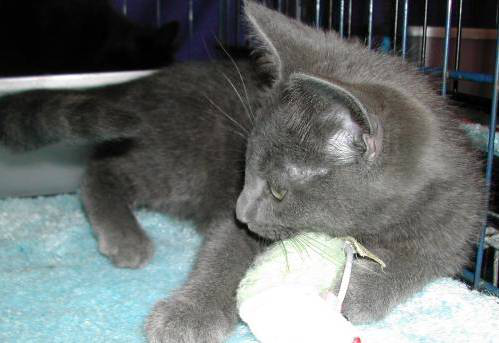

In [17]:
# 核实一下，PIL库可以展示图像
from PIL import Image
Image.open(test_path + filenames[2])

In [19]:
from utils import *

In [20]:
# 保存测试结果数组，我们后面会再次用到
save_array(results_path + 'test_preds.dat', preds)
save_array(results_path + 'filenames.dat', filenames)

## 验证预测

Keras' *fit()* function conveniently shows us the value of the loss function, and the accuracy, after every epoch ("*epoch*" refers to one full run through all training examples). The most important metrics for us to look at are for the validation set, since we want to check for over-fitting. 

- **Tip**: with our first model we should try to overfit before we start worrying about how to reduce over-fitting - there's no point even thinking about regularization, data augmentation, etc if you're still under-fitting! (We'll be looking at these techniques shortly).

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (ie those with highest probability that are correct)
4. The most incorrect labels of each class (ie those with highest probability that are incorrect)
5. The most uncertain labels (ie those with probability closest to 0.5).

Let's see what we can learn from these examples. (In general, this is a particularly useful technique for debugging problems in the model. However, since this model is so simple, there may not be too much to learn at this stage.)

Calculate predictions on validation set, so we can find correct and incorrect examples:

In [21]:
# 读取我们在之前训练保存的最后一次权重
vgg.model.load_weights(results_path+latest_weights_filename)

In [22]:
# 在验证集上测试
val_batches, probs = vgg.test(valid_path, batch_size = batch_size)

Found 2000 images belonging to 2 classes.


In [29]:
filenames = val_batches.filenames # 返回验证集上的所有文件名
expected_labels = val_batches.classes #0 or 1  真实标记

#Round our predictions to 0/1 to generate labels
our_predictions = probs[:,0]
our_labels = np.round(1-our_predictions)

In [31]:
expected_labels

array([0, 0, 0, ..., 1, 1, 1])

In [32]:
from keras.preprocessing import image

#Helper function to plot images by index in the validation set 
#Plots is a helper function in utils.py
def plots_idx(idx, titles=None):
    plots([image.load_img(valid_path + filenames[i]) for i in idx], titles=titles)
    
#Number of images to view for each visualization task
n_view = 4

Found 1796 correct labels


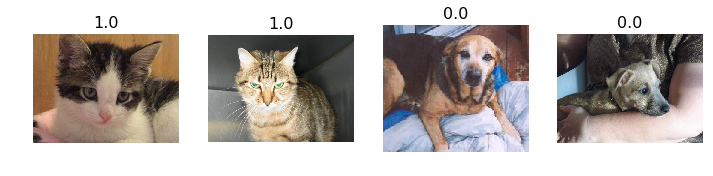

In [36]:
#1.  随机选择一些分类正确的
correct = np.where(our_labels==expected_labels)[0]
print("Found %d correct labels" % len(correct))
idx = permutation(correct)[:n_view]
plots_idx(idx, our_predictions[idx])

Found 204 incorrect labels


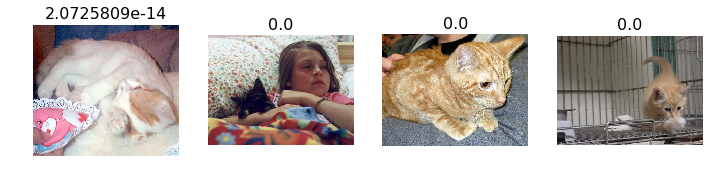

In [37]:
#2. 不正确的
incorrect = np.where(our_labels!=expected_labels)[0]
print("Found %d incorrect labels" % len(incorrect))
idx = permutation(incorrect)[:n_view]
plots_idx(idx, our_predictions[idx])

Found 825 confident correct cats labels


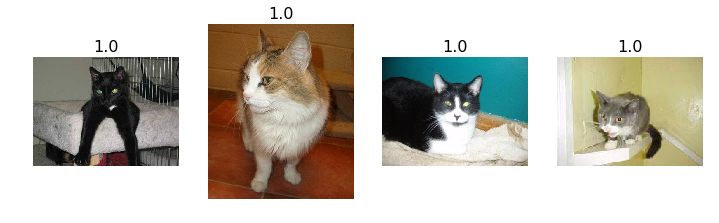

In [38]:
#3a. The images we most confident were cats, and are actually cats
correct_cats = np.where((our_labels==0) & (our_labels==expected_labels))[0]
print("Found %d confident correct cats labels" % len(correct_cats))
most_correct_cats = np.argsort(our_predictions[correct_cats])[::-1][:n_view]
plots_idx(correct_cats[most_correct_cats], our_predictions[correct_cats][most_correct_cats])

Found 971 confident correct dogs labels


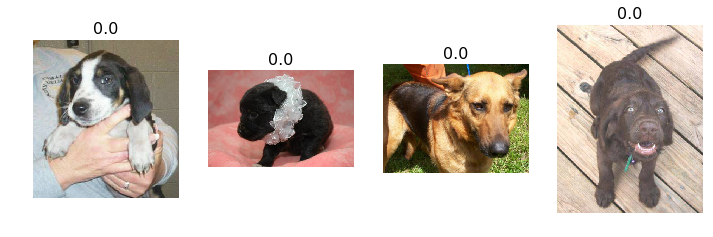

In [39]:
#3b. The images we most confident were dogs, and are actually dogs
correct_dogs = np.where((our_labels==1) & (our_labels==expected_labels))[0]
print("Found %d confident correct dogs labels" % len(correct_dogs))
most_correct_dogs = np.argsort(our_predictions[correct_dogs])[:n_view]
plots_idx(correct_dogs[most_correct_dogs], our_predictions[correct_dogs][most_correct_dogs])

Found 44 incorrect cats


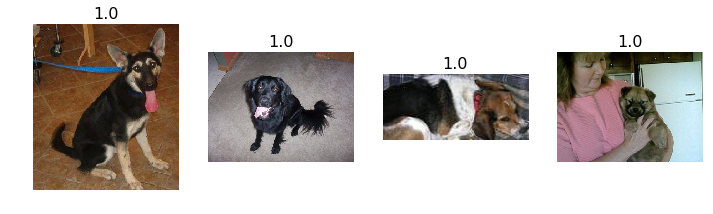

In [40]:
#4a. The images we were most confident were cats, but are actually dogs
incorrect_cats = np.where((our_labels==0) & (our_labels!=expected_labels))[0]
print("Found %d incorrect cats" % len(incorrect_cats))
if len(incorrect_cats):
    most_incorrect_cats = np.argsort(our_predictions[incorrect_cats])[::-1][:n_view]
    plots_idx(incorrect_cats[most_incorrect_cats], our_predictions[incorrect_cats][most_incorrect_cats])

Found 160 incorrect dogs


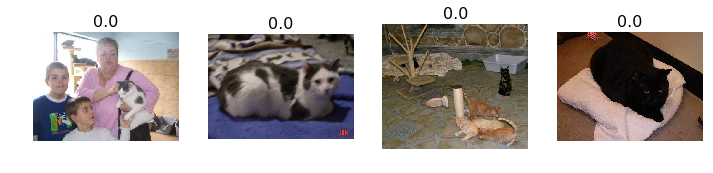

In [41]:
#4b. The images we were most confident were dogs, but are actually cats
incorrect_dogs = np.where((our_labels==1) & (our_labels!=expected_labels))[0]
print("Found %d incorrect dogs" % len(incorrect_dogs))
if len(incorrect_dogs):
    most_incorrect_dogs = np.argsort(our_predictions[incorrect_dogs])[:n_view]
    plots_idx(incorrect_dogs[most_incorrect_dogs], our_predictions[incorrect_dogs][most_incorrect_dogs])

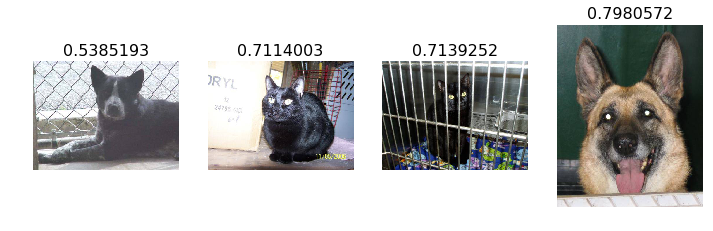

In [42]:
#5. The most uncertain labels (ie those with probability closest to 0.5).
most_uncertain = np.argsort(np.abs(our_predictions-0.5))
plots_idx(most_uncertain[:n_view], our_predictions[most_uncertain])

Perhaps the most common way to analyze the result of a classification model is to use a [confusion matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/). Scikit-learn has a convenient function we can use for this purpose:

In [43]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(expected_labels, our_labels)

We can just print out the confusion matrix, or we can show a graphical view (which is mainly useful for dependents with a larger number of categories).

[[825 160]
 [ 44 971]]


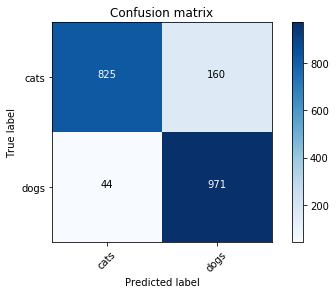

In [44]:
plot_confusion_matrix(cm, val_batches.class_indices)

## 提交结果到Kaggle！

Here's the format Kaggle requires for new submissions:
```
imageId,isDog
1242, .3984
3947, .1000
4539, .9082
2345, .0000
```

Kaggle wants the imageId followed by the probability of the image being a dog. Kaggle uses a metric called [Log Loss](http://wiki.fast.ai/index.php/Log_Loss) to evaluate your submission.

In [45]:
#Load our test predictions from file
preds = load_array(results_path + 'test_preds.dat')
filenames = load_array(results_path + 'filenames.dat')

In [46]:
#Grab the dog prediction column
isdog = preds[:,1]
print("Raw Predictions: " + str(isdog[:5]))
print("Mid Predictions: " + str(isdog[(isdog < .6) & (isdog > .4)]))
print("Edge Predictions: " + str(isdog[(isdog == 1) | (isdog == 0)]))

Raw Predictions: [1. 0. 0. 1. 1.]
Mid Predictions: [0.5443 0.4399 0.4803 0.5942 0.5205 0.4135 0.5368]
Edge Predictions: [1. 0. 0. ... 1. 1. 0.]


[Log Loss](http://wiki.fast.ai/index.php/Log_Loss) doesn't support probability values of 0 or 1--they are undefined (and we have many). Fortunately, Kaggle helps us by offsetting our 0s and 1s by a very small value. So if we upload our submission now we will have lots of .99999999 and .000000001 values. This seems good, right?

Not so. There is an additional twist due to how log loss is calculated--log loss rewards predictions that are confident and correct (p=.9999,label=1), but it punishes predictions that are confident and wrong far more (p=.0001,label=1). See visualization below.

In [51]:
#Visualize Log Loss when True value = 1
#y-axis is log loss, x-axis is probabilty that label = 1
#As you can see Log Loss increases rapidly as we approach 0
#But increases slowly as our predicted probability gets closer to 1
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import log_loss

x = [i*.0001 for i in range(1,10000)]

In [54]:
y = [log_loss([1],[[i*.0001,1-(i*.0001)]],eps=1e-15)  for i in range(1,10000,1)]

ValueError: y_true contains only one label (1). Please provide the true labels explicitly through the labels argument.

In [ ]:
plt.plot(x, y)
plt.axis([-.05, 1.1, -.8, 10])
plt.title("Log Loss when true label = 1")
plt.xlabel("predicted probability")
plt.ylabel("log loss")

plt.show()

In [55]:
#So to play it safe, we use a sneaky trick to round down our edge predictions
#Swap all ones with .95 and all zeros with .05
isdog = isdog.clip(min=0.05, max=0.95)

In [56]:
#Extract imageIds from the filenames in our test/unknown directory 
filenames = batches.filenames
ids = np.array([int(f[8:f.find('.')]) for f in filenames])

Here we join the two columns into an array of [imageId, isDog]

In [57]:
subm = np.stack([ids,isdog], axis=1)
subm[:5]

array([[1.0e+00, 9.5e-01],
       [1.0e+01, 5.0e-02],
       [1.0e+02, 5.0e-02],
       [1.0e+03, 9.5e-01],
       [1.0e+04, 9.5e-01]])

In [58]:
%cd $DATA_HOME_DIR
submission_file_name = 'submission1.csv'
np.savetxt(submission_file_name, subm, fmt='%d,%.5f', header='id,label', comments='')

C:\pythonProject\courses\deeplearning1\nbs\data\redux


In [59]:
from IPython.display import FileLink
%cd $LESSON_HOME_DIR
FileLink('data/redux/'+submission_file_name)

C:\pythonProject\courses\deeplearning1\nbs


C:\pythonProject\courses\deeplearning1\nbs\data\redux\submission1.csv

You can download this file and submit on the Kaggle website or use the Kaggle command line tool's "submit" method.